In [18]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta
#=========================
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

In [19]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2022-02-03"
end_date = "2022-02-04"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-02.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-03.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-04.csv


In [20]:
train_df = df[:int(0.7*len(df))]
val_df = df[int(0.7*len(df)):int(0.9*len(df))]
test_df = df[int(0.9*len(df)):]

In [21]:
df.drop('tic', axis=1, inplace=True)

In [22]:
def stationize(series):
    return np.log(series / series.shift(1))

In [23]:
df['log_ret'] = stationize(df['close'])
df.drop(["open","high","low", "volume"], axis=1, inplace=True)

In [24]:
df.head()

,close,log_ret
2022-02-03 00:00:00,36902.96,NaN
2022-02-03 00:00:01,36902.81,-0.000004
2022-02-03 00:00:02,36899.19,-0.000098
2022-02-03 00:00:03,36900.54,0.000037
2022-02-03 00:00:04,36895.62,-0.000133


In [35]:
train_df = df[:int(0.7*len(df))]
val_df = df[int(0.7*len(df)):int(0.9*len(df))]
test_df = df[int(0.9*len(df)):]

In [46]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss="mae",
                optimizer=tf.optimizers.Adam(),
                metrics=['mse','mape','mae'])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [36]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [37]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [113]:
def plot(self, model=None, plot_col='log_ret', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  print(len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [39]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [40]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Linear

In [80]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

In [81]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [82]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 2)
Output shape: (32, 1, 1)


In [84]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/20
  17/3780 [..............................] - ETA: 23s - loss: nan - mse: nan - mape: nan - mae: nan

2022-02-08 20:24:04.860155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3777/3780 [============================>.] - ETA: 0s - loss: nan - mse: nan - mape: nan - mae: nan

2022-02-08 20:24:26.988203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3780/3780 [==============================] - 26s 7ms/step - loss: nan - mse: nan - mape: nan - mae: nan - val_loss: nan - val_mse: nan - val_mape: nan - val_mae: nan
Epoch 2/20
3780/3780 [==============================] - 25s 7ms/step - loss: nan - mse: nan - mape: nan - mae: nan - val_loss: nan - val_mse: nan - val_mape: nan - val_mae: nan


32


InvalidArgumentError: slice index 1 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/

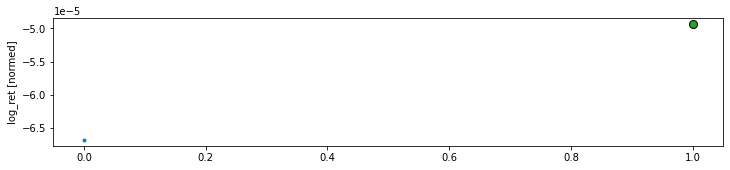

In [87]:
single_step_window.plot(linear)

## Multi-step dense

In [111]:
PAST_VIEW_WINDOW = 30
conv_window = WindowGenerator(
    input_width=PAST_VIEW_WINDOW,
    label_width=1,
    shift=1,
    label_columns=['log_ret'])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['log_ret']

32


Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

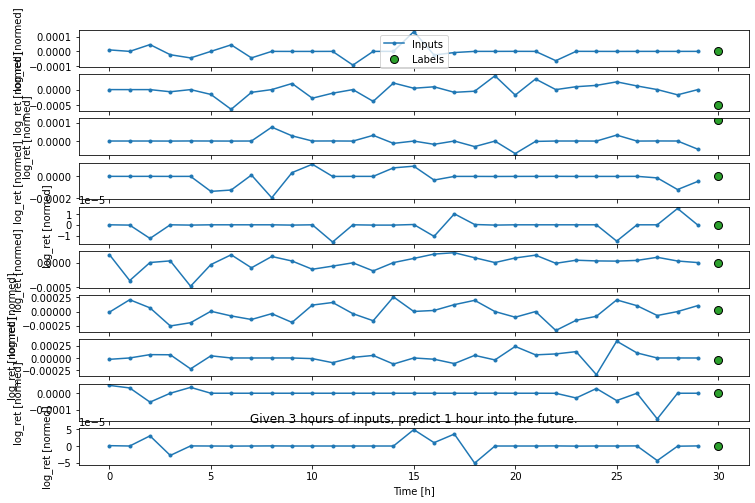

In [114]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [105]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [106]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 2)
Output shape: (32, 1, 1)


In [107]:
history = compile_and_fit(multi_step_dense, conv_window)

#IPython.display.clear_output()
#val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
#performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20


2022-02-08 21:29:38.872897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3780/3780 [==============================] - ETA: 0s - loss: 9.9500 - mse: 9825.3369 - mape: 3224779008.0000 - mae: 9.9500

2022-02-08 21:30:01.329856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3780/3780 [==============================] - 26s 7ms/step - loss: 9.9500 - mse: 9825.3369 - mape: 3224779008.0000 - mae: 9.9500 - val_loss: 1.6290e-04 - val_mse: 4.7394e-08 - val_mape: 32628.2207 - val_mae: 1.6290e-04
Epoch 2/20
3780/3780 [==============================] - 25s 7ms/step - loss: 1.1876e-04 - mse: 2.1739e-08 - mape: 32576.1504 - mae: 1.1876e-04 - val_loss: 1.5922e-04 - val_mse: 4.6168e-08 - val_mape: 31391.6973 - val_mae: 1.5922e-04
Epoch 3/20
3780/3780 [==============================] - 25s 6ms/step - loss: 8.9485e-05 - mse: 1.5355e-08 - mape: 20194.7773 - mae: 8.9485e-05 - val_loss: 1.0929e-04 - val_mse: 3.2654e-08 - val_mape: 11797.4473 - val_mae: 1.0929e-04
Epoch 4/20
3780/3780 [==============================] - 25s 7ms/step - loss: 1.0634e-04 - mse: 1.9174e-08 - mape: 27264.3008 - mae: 1.0634e-04 - val_loss: 1.5619e-04 - val_mse: 4.4055e-08 - val_mape: 30049.3574 - val_mae: 1.5619e-04
Epoch 5/20
3780/3780 [==============================] - 25s 7ms/step - loss: 1.1890

In [50]:
multi_step_dense.evaluate(conv_window.val)

1080/1080 [==============================] - 5s 5ms/step - loss: 9.9471e-05 - mse: 3.1545e-08 - mape: 7005.1860 - mae: 9.9471e-05


[9.947065700544044e-05,
 3.1544551859497005e-08,
 7005.18603515625,
 9.947065700544044e-05]

In [51]:
multi_step_dense.evaluate(conv_window.test, verbose=0)

[6.535691500175744e-05,
 1.3185992742137387e-08,
 9520.099609375,
 6.535691500175744e-05]

In [108]:
predictions = multi_step_dense.predict(conv_window.test)

2022-02-08 21:31:44.314507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32


ValueError: x and y must be the same size

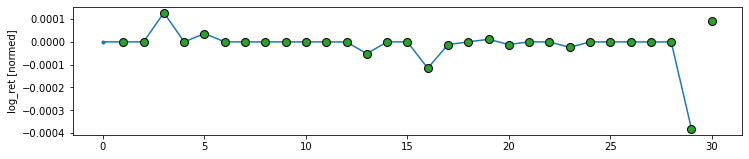

In [109]:
conv_window.plot(multi_step_dense)

https://mobiarch.wordpress.com/2020/11/13/preparing-time-series-data-for-rnn-in-tensorflow/

In [89]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array as tsdfa

In [90]:
def ts_dataset_one_step(df, window, batch_size=32):
    return tsdfa(
        df.drop('close', axis=1).to_numpy(),
        df['close'].to_numpy(),
        window,
        batch_size=batch_size
    )

In [91]:
ds_train = ts_dataset_one_step(df, 30)

In [92]:
ds_train

<BatchDataset shapes: ((None, None, 1), (None,)), types: (tf.float64, tf.float64)>

In [96]:
multi_step_dense.compile(loss="mae",
                optimizer=tf.optimizers.Adam(),
                metrics=['mse','mape','mae'])

In [100]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')